# TestCase5 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 6
version = 2
param_num = 1

In [3]:
assert testcase == 6 and version in [1,2] and param_num == 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from testcases.utils import create_tree

from testcases.geometry.geometry_2D import Donut
from modfenics.fenics_expressions.fenics_expressions_6 import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [6]:
if version == 1:
    from testcases.networks.test_2D.test_6.test_6_v1 import Run_laplacian2D,Poisson_2D
elif version == 2:
    from testcases.networks.test_2D.test_6.test_6_v2 import Run_laplacian2D,Poisson_2D
from modfenics.solver_fem.solver_fem_6 import FEMSolver
from testcases.problem.problem_2D import TestCase6
problem = TestCase6(v=version)

result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cpu


Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/u2/lecourtier/Article1/networks/test_2D/test_fe6_v2.pth
network loaded
Error  tensor([0.0009, 0.0009])


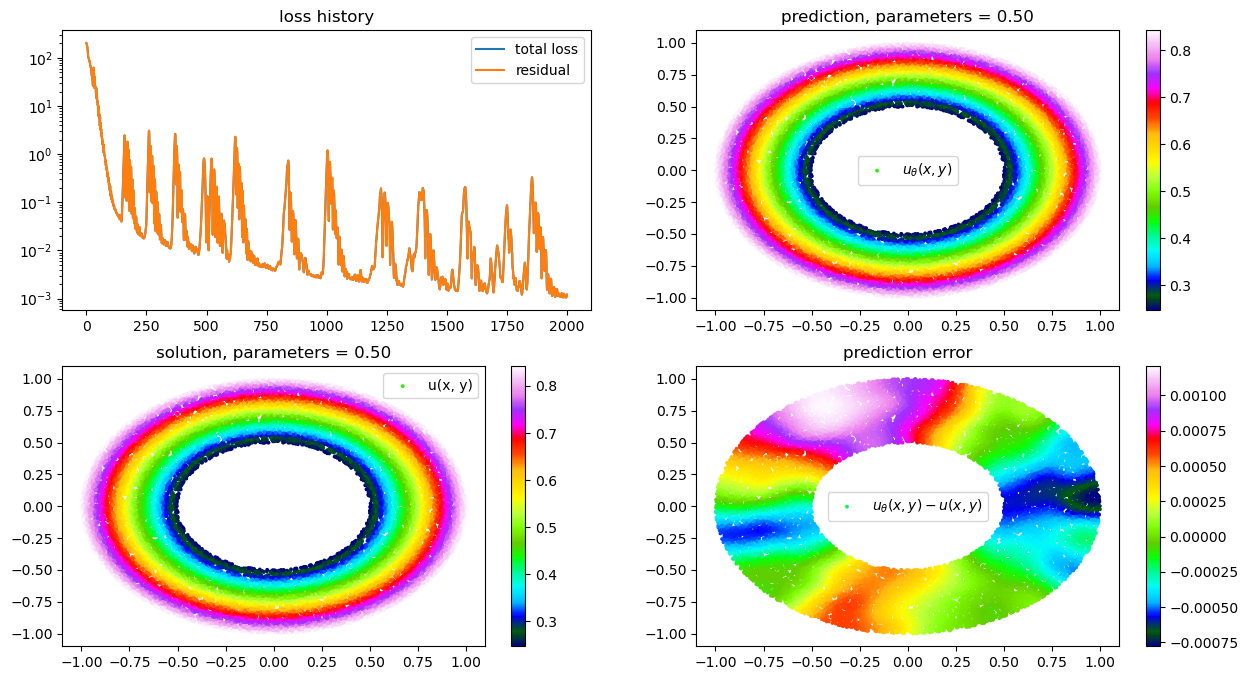

In [7]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [8]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


In [9]:
def compute_slope(i,tab_nb_vert,tab_err):
    start = [tab_nb_vert[i],tab_err[i]]
    end = [tab_nb_vert[i-1],tab_err[i-1]]
    third = [end[0],start[1]]

    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]
    ]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)

    slope = -(np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = slope.round(2)
    
    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    
    return slope,vert_mid

## Convergence FEM

In [10]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)  
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [11]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Run FEM
hmax =  0.16663035129479017
nb_vert=16, norme_L2=0.0031515619778267963
hmax =  0.08691933730437637
nb_vert=32, norme_L2=0.0008013962272998324
hmax =  0.04347038548979546
nb_vert=64, norme_L2=0.00020117350353494006
hmax =  0.02197797091453632
nb_vert=128, norme_L2=5.140171329117128e-05
hmax =  0.010988924822874708
nb_vert=256, norme_L2=1.282492637605861e-05


degree=1
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree1.csv
degree=2
Run FEM
hmax =  0.16663035129479017
nb_vert=16, norme_L2=0.0001381991055607216
hmax =  0.08691933730437637
nb_vert=32, norme_L2=1.9526767362956258e-05
hmax =  0.04347038548979546
nb_vert=64, norme_L2=2.3165127305254103e-06
hmax =  0.02197797091453632
nb_vert=128, norme_L2=2.9878432246099703e-07
hmax =  0.010988924822874708
nb_vert=256, norme_L2=3.717689695992567e-08
degree=3
Run FEM
hmax =  0.16663035129479017
nb_vert=16, norme_L2=2.8948195420953706e-06
hmax =  0.08691933730437637
nb_vert=32, norme_L2=1.9733632566653687e-07
hmax =  0.04347038548979546
nb_vert=64, norme_L2=1.1545461573943746e-08
hmax =  0.02197797091453632
nb_vert=128, norme_L2=9.783175022364617e-10
hmax =  0.010988924822874708
nb_vert=256, norme_L2=2.0274127314936765e-09


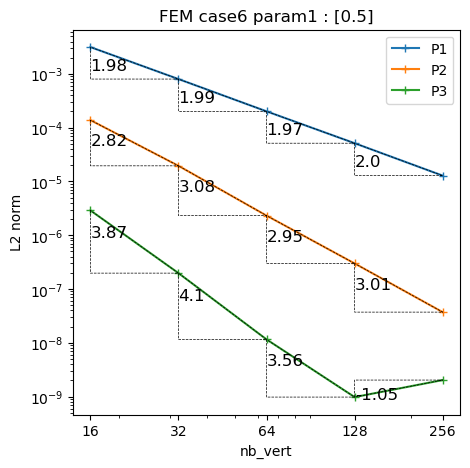

In [12]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope for each segment
    for i in range(1,len(tab_nb_vert_FEM)):
        slope, vert_mid = compute_slope(i,tab_nb_vert_FEM,tab_err_FEM)
        plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [13]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree3.csv


## Convergence PINNs+Corr

In [14]:
def get_test_sample(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

def FEniCSpred(i,V_test,trainer):
    X_test,mu_test = get_test_sample(i,V_test,trainer)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
    
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()

    return u_PINNs

In [15]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False,plot_all = False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            
            tab_h_Corr.append(solver.h)
            
            # Compute PINNs solution
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            u_PINNs = FEniCSpred(0,V_test,trainer)
            u_PINNs_inter = FEniCSpred(0,solver.V,trainer)
            
            # Compute PINNs Error
            u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
            
            uref_Vex = df.interpolate(u_ref,solver.V_ex)
            sol_Vex = df.interpolate(u_PINNs,solver.V_ex)
            norme_L2_PINNs = (df.assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"# norme_L2_PINNs={norme_L2_PINNs}")

            sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_inter)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
            #### PLOTT
            if plot_all and nb_vert in [16,32,64]:
                colormap = "jet"

                C_ex = df.Function(solver.V)
                u_ref_inter = df.interpolate(u_ref,solver.V)
                C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_inter.vector()[:]

                plt.figure(figsize=(15,10))

                plt.subplot(2,3,1)
                c = df.plot(C_ex,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex")

                plt.subplot(2,3,2)
                c = df.plot(C_tild,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_tild")

                plt.subplot(2,3,3)
                error = df.Function(solver.V)
                error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex-C_tild")
                
                plt.subplot(2,3,4)
                c = df.plot(u_ref_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("u_ex")
                
                plt.subplot(2,3,5)
                # sol_inter = df.project(sol,solver.V)
                sol_inter = df.Function(solver.V)
                sol_inter.vector()[:] = u_PINNs_inter.vector()[:] + C_tild.vector()[:]
                c = df.plot(sol_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("sol")
                
                plt.subplot(2,3,6)
                error = df.Function(solver.V)
                error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    
                
                plt.suptitle(f"nb_vert={nb_vert}")
                
                plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}.png')

        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [16]:
degree = 3
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree)

hmax =  0.16663035129479017
# norme_L2_PINNs=0.000892379357895779
nb_vert=16, norme_L2=7.575529102419908e-07
hmax =  0.08691933730437637
# norme_L2_PINNs=0.0008893415654959142
nb_vert=32, norme_L2=6.54043204291728e-08
hmax =  0.04347038548979546
# norme_L2_PINNs=0.000888462380564
nb_vert=64, norme_L2=4.573841039043818e-09
hmax =  0.02197797091453632
# norme_L2_PINNs=0.0008882466657526509
nb_vert=128, norme_L2=5.580356645819802e-09
hmax =  0.010988924822874708
# norme_L2_PINNs=0.0008881911522331456
nb_vert=256, norme_L2=2.2313863282369874e-08


degree=1
hmax =  0.16663035129479017
# norme_L2_PINNs=0.000892379357895779
nb_vert=16, norme_L2=2.4482961184696716e-05
hmax =  0.08691933730437637
# norme_L2_PINNs=0.0008893415654959142
nb_vert=32, norme_L2=6.439585918350264e-06
hmax =  0.04347038548979546
# norme_L2_PINNs=0.000888462380564
nb_vert=64, norme_L2=1.6862647401432695e-06
hmax =  0.02197797091453632
# norme_L2_PINNs=0.0008882466657526509
nb_vert=128, norme_L2=4.371517501533222e-07
hmax =  0.010988924822874708
# norme_L2_PINNs=0.0008881911522331456
nb_vert=256, norme_L2=1.1222803950960784e-07
degree=2
hmax =  0.16663035129479017
# norme_L2_PINNs=0.000892379357895779
nb_vert=16, norme_L2=3.208886680421348e-06
hmax =  0.08691933730437637
# norme_L2_PINNs=0.0008893415654959142
nb_vert=32, norme_L2=4.754876219904594e-07
hmax =  0.04347038548979546
# norme_L2_PINNs=0.000888462380564
nb_vert=64, norme_L2=6.325123781466282e-08
hmax =  0.02197797091453632
# norme_L2_PINNs=0.0008882466657526509
nb_vert=128, norme_L2=1.024313167869967

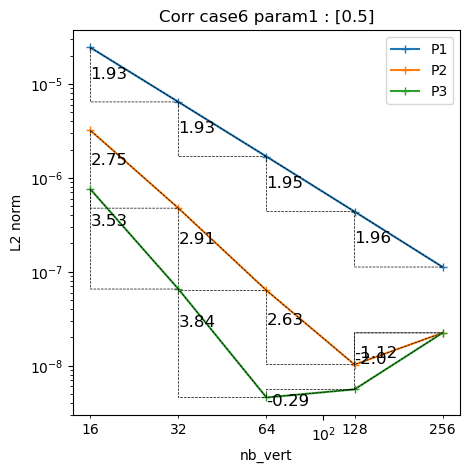

In [17]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))

    # add slope for each segment
    for i in range(1,len(tab_nb_vert_Corr)):
        slope, vert_mid = compute_slope(i,tab_nb_vert_Corr,tab_err_Corr)
        plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [18]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree3.csv


## Plots

degree=1
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/FEM_case6_param1_degree3.csv
degree=1
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase6/version2/cvg/Corr_case6_param1_degree3.csv


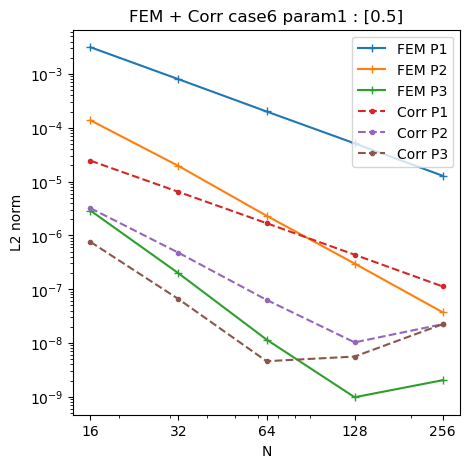

In [19]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')